<a href="https://colab.research.google.com/github/MANOJ-80/Fraud-Detection-NM/blob/main/CreditCard_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn joblib shap xgboost lightgbm catboost



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE


In [3]:
df = pd.read_csv('/content/creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
print(df.isnull().sum())
df.drop_duplicates(inplace=True)


Time      0
V1        1
V2        1
V3        1
V4        1
V5        1
V6        1
V7        1
V8        1
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64


In [5]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])


In [7]:
print("Missing in Class column:", df['Class'].isnull().sum())

df = df.dropna(subset=['Class'])

print("After cleaning:", df['Class'].isnull().sum())

X = df.drop('Class', axis=1)
y = df['Class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Missing in Class column: 1
After cleaning: 0


In [8]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [10]:
rf_smote_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_model.fit(X_train_smote, y_train_smote)


RandomForestClassifier(random_state=42)

In [11]:
y_pred = rf_model.predict(X_test)
print("Normal RandomForest")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))


Normal RandomForest
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5523
         1.0       0.89      0.89      0.89        19

    accuracy                           1.00      5542
   macro avg       0.95      0.95      0.95      5542
weighted avg       1.00      1.00      1.00      5542

[[5521    2]
 [   2   17]]
AUC: 0.9471873600350686


In [12]:
y_pred_smote = rf_smote_model.predict(X_test)
print("SMOTE RandomForest")
print(classification_report(y_test, y_pred_smote))
print(confusion_matrix(y_test, y_pred_smote))
print("AUC:", roc_auc_score(y_test, y_pred_smote))


SMOTE RandomForest
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5523
         1.0       0.89      0.89      0.89        19

    accuracy                           1.00      5542
   macro avg       0.95      0.95      0.95      5542
weighted avg       1.00      1.00      1.00      5542

[[5521    2]
 [   2   17]]
AUC: 0.9471873600350686


In [13]:
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(rf_smote_model, 'random_forest_smote_model.pkl')


['random_forest_smote_model.pkl']

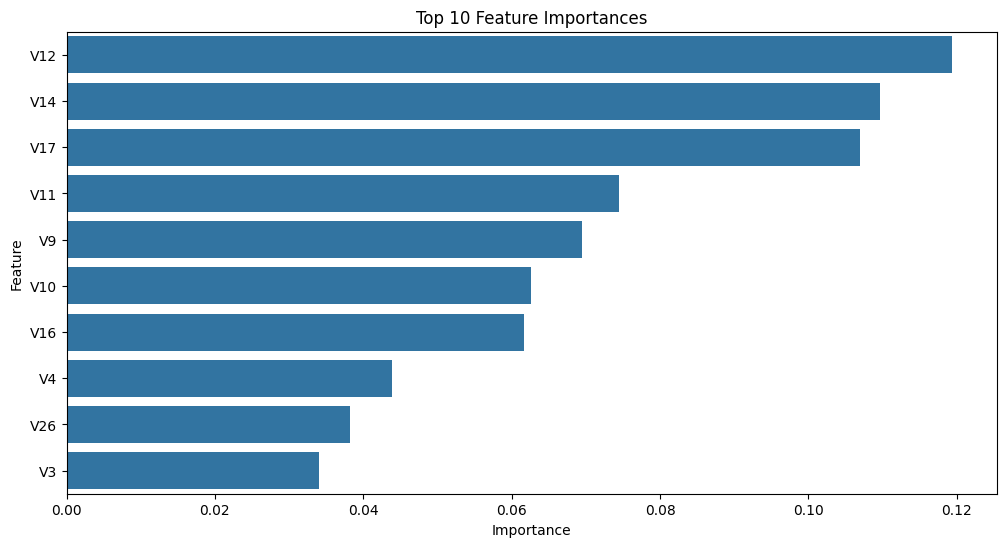

In [14]:
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()


In [21]:
from google.colab import files

files.download('random_forest_model.pkl')
files.download('random_forest_smote_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
print(X_train.shape)


(22165, 30)


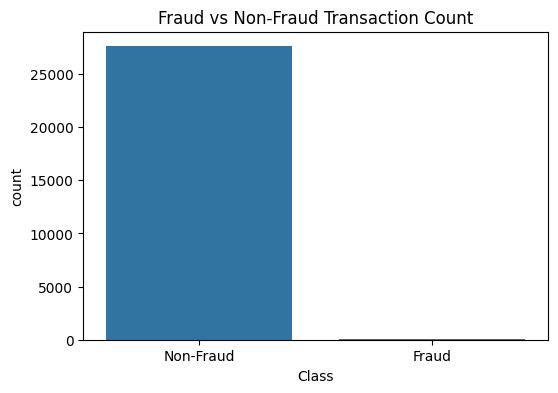

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Transaction Count")
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.show()


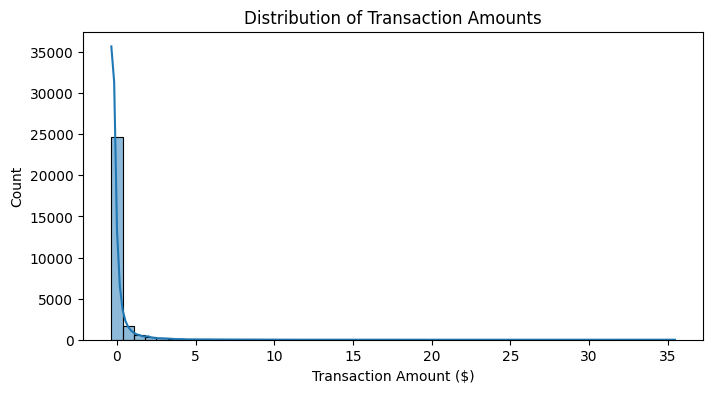

In [23]:
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount ($)")
plt.show()


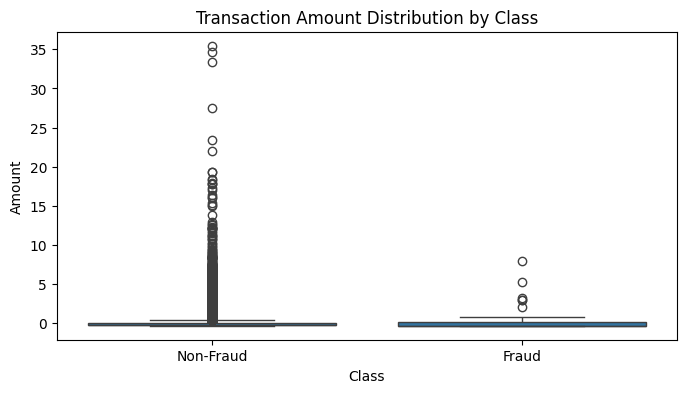

In [24]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Transaction Amount Distribution by Class")
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.show()


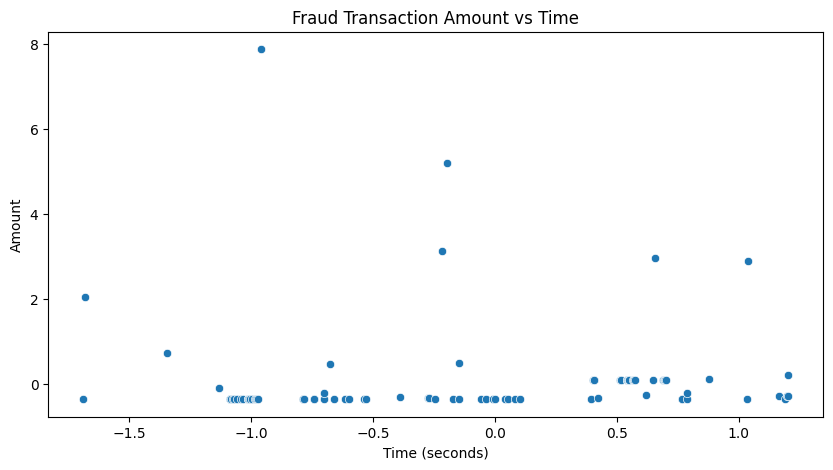

In [25]:
fraud_df = df[df['Class'] == 1]

plt.figure(figsize=(10,5))
sns.scatterplot(x='Time', y='Amount', data=fraud_df)
plt.title("Fraud Transaction Amount vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")
plt.show()


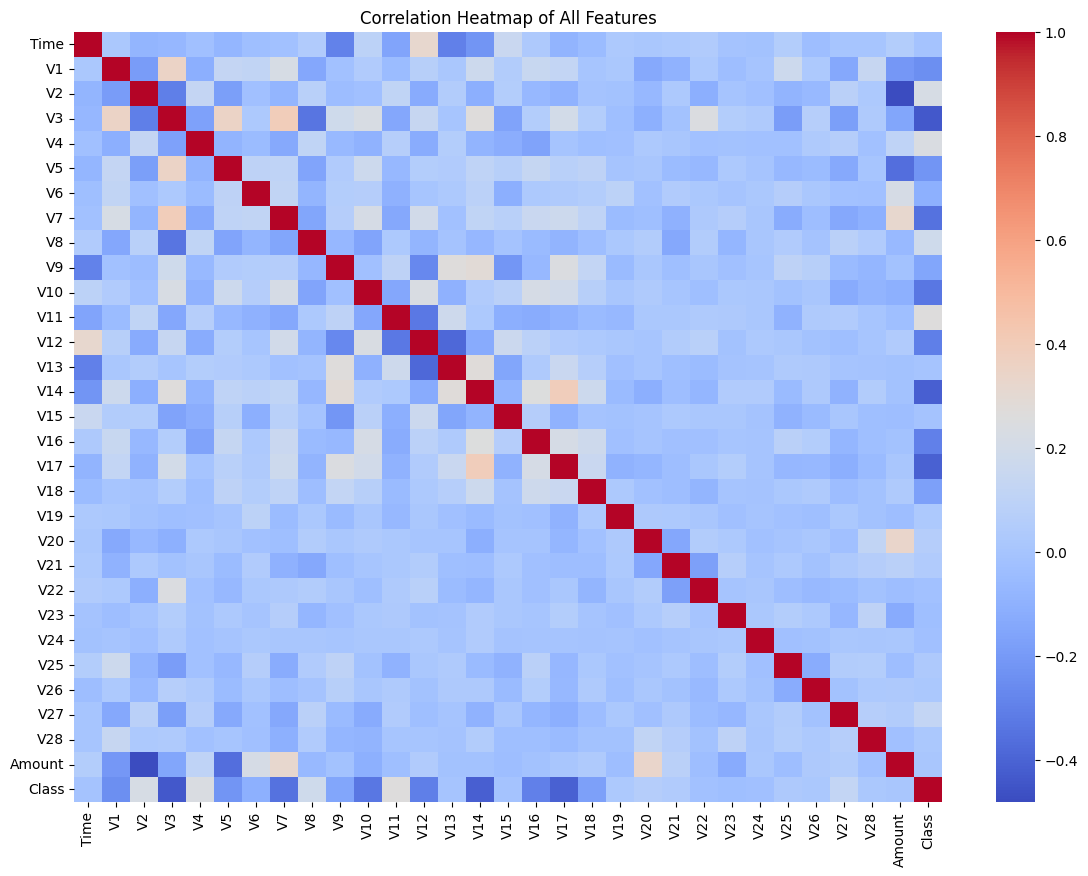

In [26]:
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of All Features")
plt.show()


<ipython-input-27-14f4264be2b2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='viridis')


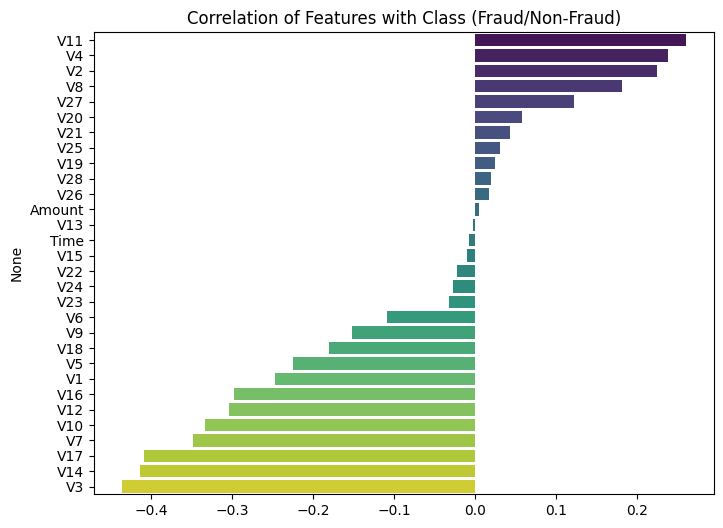

In [27]:
corr_target = df.corr()['Class'].drop('Class').sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='viridis')
plt.title("Correlation of Features with Class (Fraud/Non-Fraud)")
plt.show()


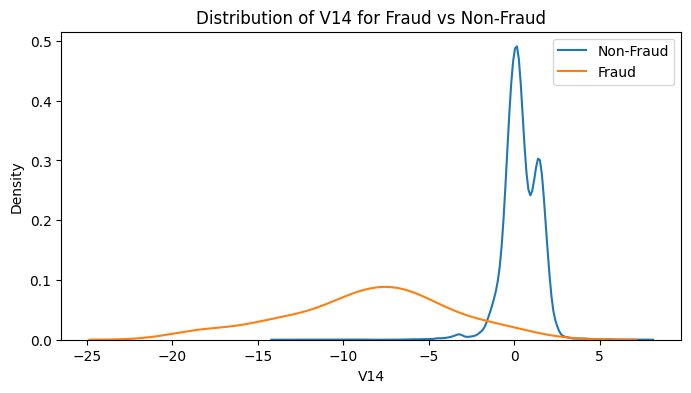

In [28]:
plt.figure(figsize=(8,4))
sns.kdeplot(df.loc[df['Class'] == 0, 'V14'], label='Non-Fraud')
sns.kdeplot(df.loc[df['Class'] == 1, 'V14'], label='Fraud')
plt.title("Distribution of V14 for Fraud vs Non-Fraud")
plt.legend()
plt.show()
